# Travel time estimation using tensor decomposition

Resources:

https://www.microsoft.com/en-us/research/publication/trajectory-data-mining-an-overview/ 

https://www.microsoft.com/en-us/research/wp-content/uploads/2015/09/TrajectoryDataMining-tist-yuzheng.pdf


Formula to implement:


\begin{aligned}
\mathcal{L}(S, R, U, T, F, G)=&\frac{1}{2}\left\|\mathcal{A}-S \times_R R \times_U U \times_T T\right\|^2+\frac{\lambda_1}{2}\|X-T G\|^2 \\
+&\frac{\lambda_2}{2}\|Y-R F\|^2+\frac{\lambda_3}{2}\left(\|S\|^2+\|R\|^2+\|U\|^2+\|T\|^2+\|F\|^2+\|G\|^2\right)
\end{aligned}







## Formula explanation

This formula describes the loss function for a tensor decomposition (factorization) method in order to estimate the three-dimensional tensor $\mathcal{A}$. 

$\mathcal{A}$ encodes the user-specific travel time in the following way: and entry $\mathcal{A_{ijk}}$ of $\mathcal{A}$ is the time that the $j$-th driver takes to travel in the $i$-th road segment in the $k$-th daily time slot. Therefore $\mathcal{A}$ is essentially a three dimensional array. We can know certain entries of this tensor by tracking user's GPS signal, but a large amount of entries in this tensor are unknowns, as users will only drive in certain roads at certain times, therefore we aim to estimate them. Intuitively, we could try to guess some of the missing entries based on existing ones by eyeballing correlations in the data: for example, if at a given time of the day the travel time for users is large in certain road segments, we expect that there is traffic there, and therefore we can estimate long travel times for other drivers, too.


In order to help doing this 2 more matrices are introduced: $X$ and $Y$, with their associated term in the loss function enabling the factorization of each of them as the product of two matrices. $X$ represents the correlation between time slots and coarse grained traffic conditions (precisely number of vehicles transiting in a grid slot in a given time interval), while $Y$ stores road segments geographical features.

Finally, a regularization term is added in order to prevent overfitting, this term in the loss function helps keeping all the components of the matrices and tensors small.

We need to estimate the tensor $\mathcal{A}$ by decomposing it into a product. The measure of the "fitness" of the decomposition is given by the sum of the square of the difference between the entries for which A is known and its decomposition $\phi =S \times_R R \times_U U \times_T T $, ie.e the Frobenius norm $||\mathcal{A}- \phi||_{F}$ and similarly with the matrices $X$ and $Y$. 

More explicitely:

$$||\mathcal{A}- \phi||_{F}= \sum_i \sum_j \sum_k (A_{ijk}-\phi_{ijk})^2$$

From this, we compute the gradient of this loss function with respect each component of the matrices we decompose A into, and use this in a gradient descent algorithm. Each iteration computes the gradient and updates the matrices in such a way the loss is minimized.

In synthesis, this is an optimization algorithm in which array are factorized in lower rank arrays, in order to minimize the squared difference between the entries of the given array and the one estimated with the factorization. 

Data types involved are at most rank-3 numerical arrays. The input are the arrays $\mathcal{A}$, $X$, and $Y$, obtained by data mining, e.g. by analyzing GPS trajectories, maps etc.. The output is the tensor $\mathcal{A}$ estimated by the product (more precisely the contraction) of the tensor $S$ with $R$, $U$, $T$, all estimated in the optimization algorithm.

In order to develop the algorithm one can use many possible programming language and libraries. 

An algorithm using he library numpy can get the job done, however more advanced packages such as scipy, tensorly, scikit-learn, pytorch and tensorflow all offer already developed methods to implement such algorithm, as optimization problems involving tensors are quite common in the field of data science.

A key point to consider is that we only know some entries of the tensor $\mathcal{A}$, and we can only use those in order to estimate the factor tensors $S$, $R$, $U$, $T$. 


## Implementation (prototype solution)

An example of a gradient descent algorithm and its implementation is given below. The gradient is computed. Then for each $i$, $j$, $k$, for which the tensor $\mathcal{A}$ is known, the gradient is used to update the variables:

\begin{aligned}
\phi_{i j k}= & S \times_R R_{i *} \times_U U_{j *} \times_T T_{k *} ; \\
R_{i *} & \leftarrow R_{i *}-\eta \lambda_3 R_{i *}-\eta\left(\phi_{i j k}-\mathcal{A}_{i j k}\right) \times S \times_U U_{j *} \times_T T_{k *} \\
& -\eta \lambda_2\left(R_{i *} \times F-Y_{i *}\right) \times F ; \\
U_{j *} \leftarrow & U_{j *}-\eta \lambda_3 U_{j *}-\eta\left(\phi_{i j k}-\mathcal{A}_{i j k}\right) \times S \times_R R_{i *} \times_T T_{k *} \\
T_{k *} \leftarrow & T_{k *}-\eta \lambda_3 T_{k *}-\eta\left(\phi_{i j k}-\mathcal{A}_{i j k}\right) \times S \times_R R_{i *} \times_U U_{j *} \\
& \quad-\eta \lambda_1\left(T_{k *} \times G-X_{k *}\right) \times G ; \\
S \leftarrow & S-\eta \lambda_3 S-\eta\left(\phi_{i j k}-\mathcal{A}_{i j k}\right) \times R_{i *} \otimes U_{j *} \otimes T_{k *} \\
G \leftarrow & G-\eta \lambda_3 G-\eta \lambda_1\left(T_{k *} \times G-X_{k *}\right) \times T_{k *} \\
F \leftarrow & F-\eta \lambda_3 F-\eta \lambda_2\left(R_{i *} \times F-Y_{i *}\right) \times R_{i *}
\end{aligned}

Note: there are also automatic ways to compute the gradient of a function wrt its argument, such as automatic differentiation in pytorch and tensorflow.

There are also several other optimization techniques that do not involve computing gradients.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda #to speed up calculations

In [113]:
def phi_tensor(s,r,u,t):
    ''' phi tensor, defined above.
    it's the product of the tensor s with the matrices r,u,t
    has the same dimensions of A'''
    return np.einsum('ijk,ai,bj,ck->abc',s,r,u,t)
    
#@jit(target_backend='cuda')
def phi_ijk(s,r,u,t,a,b,c):
    '''(i,j,k)th component of phi,
    i.e. the contraction of s with r,u,t tensors'''
    return np.einsum('ijk,i,j,k->',s,r[a,:],u[b,:],t[c,:])
def phi_ijk_2(s,ri,uj,tk):
    '''a possibly more optimized version
    ri,uj,tk=r[i,:],u[j,:],t[k,:]'''
    return np.einsum('ijk,i,j,k->',s,ri,uj,tk)
def rut(r,u,t,a,b,c):
    '''tensor product of i,j,k th components
    of r,u,t'''
    return np.einsum('i,j,k->ijk',r[a,:],u[b,:],t[c,:])
def compute_loss(a,x,y,s,r,u,t,f,g,lamb1=1,lamb2=1,lamb3=1):
    '''implementation of the loss function itself.
    the loss is composed by the sum of 4 different terms,
    they will be computed separately
    1st term is the one involving a
    2nd involves x
    3rd involves y
    4 is the regularization
    '''
    #problem: should sum only for i,j,k for which a_ijk >0: so I should implements a mask
    phi=phi_tensor(s,r,u,t)
    mask=np.where(a > 0, 1, 0)
    first=np.linalg.norm((a-phi)*mask)**2
    second=np.linalg.norm(x-t@g)**2
    third=np.linalg.norm(y-r@f)**2
    fourth=np.linalg.norm(s)**2+ np.linalg.norm(r)**2+ np.linalg.norm(u)**2+ np.linalg.norm(t)**2+ np.linalg.norm(f)**2+ np.linalg.norm(g)**2
    loss=0.5*first+0.5*lamb1*second+lamb2*0.5*third+lamb3*0.5*fourth
    return loss
def compute_loss_a(a,x,y,s,r,u,t):
    '''only computes the loss of a
    '''
    #problem: should sum only for i,j,k for which a_ijk >0: so I should implements a mask
    phi=phi_tensor(s,r,u,t)
    mask=np.where(a > 0, 1, 0)
    first=np.linalg.norm((a-phi)*mask)**2
    loss=0.5*first
    return loss

In [114]:
#latent dimensions
dU=5
dR=7
dT=3
# dimensions of X,Y tensor
dX=11 #aka p
dY=13 #aka q
# dimensions of A tensor
n=3 #road segments
m= 9 #drivers
l= 4#time slots


In [115]:
#factorization tensors initialization. Those are the tensors the algorithm has to output

s=np.random.rand(dR,dU,dT)
r=np.random.rand(n,dR)
u=np.random.rand(m,dU)
t=np.random.rand(2*l,dT)
phi=np.einsum('ijk,ai,bj,ck->abc',s,r,u,t)#tensor contraction between s,r,u,t: should be a nxmx2l tensor
f=np.random.rand(dR,dY)
g=np.random.rand(dT,dX)

In [116]:
## those tensors would be computed from available data, here in this toy model I randomly initialize them

a=np.random.randint(0,15,size=(n,m,2*l))
x=np.random.randint(0,5,size=(2*l,dX))
y=np.random.randint(0,4,size=(n,dY))

print(a.shape)

(3, 9, 8)


In [117]:
np.linalg.norm(a)**2

14084.999999999998

In [118]:
mask=np.where(a > 0, 1, 0)#select only entries where a is greater than 0

In [119]:
phi=phi_tensor(s,r,u,t)
np.einsum('abc,abc,abc->',a-phi,a-phi,mask)

6102.2258903513675

In [120]:
np.einsum('abc,abc->',(a-phi)*mask,(a-phi)*mask)

6102.225890351367

In [121]:
np.einsum('abc,abc->',a-phi,a-phi)

7290.850222333576

In [122]:
i,j,k=0,1,5
phi[i][j][k]

9.011625355292061

In [123]:
(t@g-x)[k,:].shape

(11,)

In [124]:
t.T[:,k]

array([0.86497765, 0.82840807, 0.87438179])

In [125]:
np.einsum('a,b->ab',t.T[:,k],(t@g-x)[k,:])

array([[-2.19082937, -0.13959644, -2.17395639,  1.25816069,  0.41320911,
        -3.06996411, -2.18608219, -0.74990821,  1.39505449, -2.78583262,
        -1.00486581],
       [-2.09820536, -0.13369457, -2.08204574,  1.2049681 ,  0.39573943,
        -2.94017199, -2.09365888, -0.71820355,  1.33607429, -2.66805303,
        -0.96238203],
       [-2.21464834, -0.14111415, -2.19759192,  1.27183957,  0.41770157,
        -3.10334114, -2.20984955, -0.75806131,  1.4102217 , -2.81612054,
        -1.01579083]])

In [126]:
np.tensordot( t[k,:],t[k,:]@g-x[k,:],axes=0)

array([[-2.19082937, -0.13959644, -2.17395639,  1.25816069,  0.41320911,
        -3.06996411, -2.18608219, -0.74990821,  1.39505449, -2.78583262,
        -1.00486581],
       [-2.09820536, -0.13369457, -2.08204574,  1.2049681 ,  0.39573943,
        -2.94017199, -2.09365888, -0.71820355,  1.33607429, -2.66805303,
        -0.96238203],
       [-2.21464834, -0.14111415, -2.19759192,  1.27183957,  0.41770157,
        -3.10334114, -2.20984955, -0.75806131,  1.4102217 , -2.81612054,
        -1.01579083]])

In [127]:
np.einsum('ijk,i,j,k->',s,r[i,:],u[j,:],t[k,:])

9.011625355292061

In [128]:
print(rut(r,u,t,0,0,0).shape)

(7, 5, 3)


In [129]:
np.einsum('abc,b,c->a',s,u[j],t[k]).shape

(7,)

In [130]:
r[i,:]-(phi_ijk(s,r,u,t,i,j,k)-a[i,j,k])*np.einsum('abc,b,c->a',s,u[j],t[k])-(r[i]@f-y[i])@f.T

array([7.45026381, 4.43098866, 5.25643655, 4.36030085, 6.406081  ,
       5.03003286, 0.7091586 ])

In [131]:
#@jit(target_backend='cuda')
def matrix_factorization(a,x,y,epsilon=0.001,steps=1000,eta=0.001,dR=10,dU=10,dT=10,lamb1=1,lamb2=1,lamb3=1):
    '''
    element-wise optimization algorithm
    a: target tensor of shape n x m x l 
    x,y: context matrices
    steps: max iterations
    eta: learning rate
    epsilon: treshold for early stop
    dR,dU,dT: dimensions of latent spaces
    '''
    n,m,twol=a.shape
    dG=x.shape[1]
    dF=y.shape[1]
    #initialize s,r,u,t,f,g
    s=np.random.rand(dR,dU,dT)
    r=np.random.rand(n,dR)
    u=np.random.rand(m,dU)
    t=np.random.rand(twol,dT)
    f=np.random.rand(dR,dF)
    g=np.random.rand(dT,dG)
    #for i,j,k for which a[ijk]=! 0
        #compute gradient of loss
    losses=[]
    losses_a=[]
    for steps in range(steps):
        if True :#loss_i-loss_i-1 > epsilon
            for i in range(n):
                for j in range(m):
                    for k in range(twol):
                        if a[i,j,k]>0:
                            phiijk=phi_ijk(s,r,u,t,i,j,k)
                            #compute all gradients
                            gradr=lamb3* r[i,:]+(phi_ijk(s,r,u,t,i,j,k)-a[i,j,k])*np.einsum('abc,b,c->a',s,u[j],t[k])+lamb2*(r[i]@f-y[i])@f.T
                            gradu=lamb3* u[j,:]+(phi_ijk(s,r,u,t,i,j,k)-a[i,j,k])*np.einsum('abc,a,c->b',s,r[i],t[k])
                            gradt=lamb3* t[k,:]+(phi_ijk(s,r,u,t,i,j,k)-a[i,j,k])*np.einsum('abc,a,b->c',s,r[i],u[j])+lamb1*(t[k]@g-x[k])@g.T
                            grads=lamb3*s+ (phi_ijk(s,r,u,t,i,j,k)-a[i,j,k])*rut(r,u,t,i,j,k)
                            gradg=lamb3*g+lamb1*np.tensordot( t[k,:],t[k,:]@g-x[k,:],axes=0)
                            gradf=lamb3*f+lamb2*np.tensordot( r[i,:],r[i,:]@f-y[i,:],axes=0)
                            #update all parameters
                            r[i]=r[i] - eta*gradr
                            u[j]=u[j] - eta*gradu
                            t[k]=t[k] - eta*gradt
                            g=g - gradg*eta
                            f=f - gradf*eta
                            s=s - eta*grads

        #here, compute loss
        loss=compute_loss(a,x,y,s,r,u,t,f,g,lamb1,lamb2,lamb3)
        loss_a=compute_loss_a(a,x,y,s,r,u,t)
        losses.append(loss)
        losses_a.append(loss_a)
    return s,r,u,t,losses,losses_a

In [132]:
s,r,u,t,losses,losses_a=matrix_factorization(a,x,y)

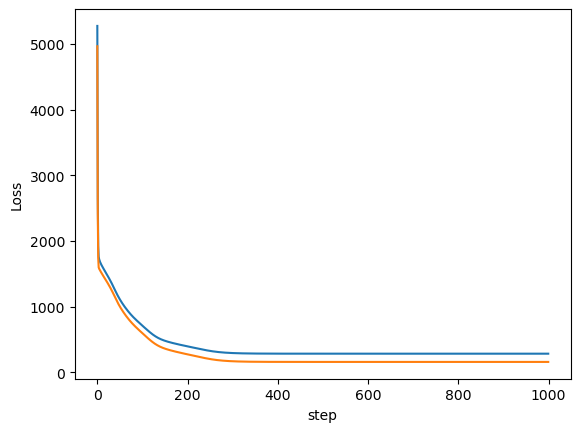

In [133]:
plt.plot(losses)
plt.plot(losses_a)
plt.ylabel('Loss')
plt.xlabel('step')
plt.show()

In [134]:
a[0]

array([[ 3, 10,  6,  8,  7,  9,  6,  6],
       [ 6,  4, 10,  1,  2, 13, 12,  1],
       [ 4,  8,  7, 14,  4,  5,  0, 11],
       [10,  2,  1,  7,  9,  9, 13,  2],
       [ 5,  5, 11,  6,  0,  6,  8,  5],
       [ 4,  4, 14,  3, 14, 10,  0, 12],
       [13,  9, 10,  4,  3, 12, 10, 12],
       [ 6,  3, 12,  5,  5, 11,  0,  3],
       [14,  9,  3,  0,  3,  1, 11,  3]])

In [135]:
phi_tensor(s,r,u,t)[0]

array([[ 4.25328777,  8.19467427,  7.36670572,  6.82475898,  7.87880502,
         7.33981308,  6.77610273,  6.67886916],
       [ 7.26494824,  3.80536241,  9.87681572,  3.60697425,  5.54295812,
        10.98820721,  8.2537634 ,  3.88210945],
       [ 6.40224338,  7.7745012 ,  6.70399854, 10.7399843 ,  4.4553875 ,
         5.81733792,  7.50638182,  8.34699941],
       [ 9.00861933,  3.39975574,  3.12562314,  6.78026777,  7.14471383,
         7.8813562 , 10.73898468,  2.73802507],
       [ 5.33016576,  4.78099868,  9.90088436,  5.46756447,  8.12397911,
         6.45903508,  7.75069288,  5.33617846],
       [ 4.48718622,  5.9473963 , 12.70061159,  4.12963429, 12.28088582,
         9.14716666,  7.48062338, 10.89005849],
       [12.25707102,  9.31095317,  9.35237105,  5.69929549,  5.2971116 ,
        10.65825923,  9.27020118,  8.85626888],
       [ 5.61290921,  3.43351152, 10.23865864,  4.1066802 ,  5.63292315,
         9.9148658 ,  5.44800278,  3.75755405],
       [10.921014  ,  7.55683971

Tensorflow implementation

In [142]:
import tensorflow as tf

def custom_loss(data, approx, mask):#how to obtain mask?
    known_data = tf.boolean_mask(data, mask)
    known_approx = tf.boolean_mask(approx, mask)
    return tf.norm(known_data - known_approx)

def factorize_tensor(data, mask, dU=10,dT=10,dR=10):#todo: change arguments
    n,m,twol=data.shape
    core_tensor = tf.Variable(tf.random.normal([dU,dT,dR]))
    user_matrix = tf.Variable(tf.random.normal([m,dU]))
    time_matrix = tf.Variable(tf.random.normal([twol,dT]))
    road_matrix = tf.Variable(tf.random.normal([n,dR]))

    approx_tensor = tf.einsum('ijk,ai,bj,ck->abc', core_tensor,road_matrix, user_matrix, time_matrix)
    loss = custom_loss(data, approx_tensor, mask)
    optimizer = tf.optimizers.Adam()

    for i in range(1000): # number of optimization steps
        with tf.GradientTape() as tape:
            tape.watch([core_tensor, user_matrix, time_matrix, road_matrix])
            current_loss = custom_loss(data, approx_tensor, mask)
        gradients = tape.gradient(current_loss, [core_tensor, user_matrix, time_matrix, road_matrix])
        optimizer.apply_gradients(zip(gradients, [core_tensor, user_matrix, time_matrix, road_matrix]))

    return core_tensor, user_matrix, time_matrix, road_matrix


In [143]:
factorize_tensor(a,mask=np.where(a > 0, 1, 0))

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Sub]